In [18]:
!pip install torch torchvision

In [24]:
from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

@app.route("/upload", methods=["GET", "POST"])
def upload_file():
    if request.method == "POST" :
        
        file_name = request.form.get("fileName")
        file_extension = request.form.get("fileExtension")
        user_id = request.form.get("user_id")
        orign_file = f"{file_name}.{file_extension}"
        
        print(file_name)
        print(file_extension)
        print(orign_file)
        print(user_id)
        
        main(orign_file, user_id)
        graph(orign_file, user_id)
        save(oring_file,user_id)
        return "성공"
    else :
        print(request.args.get("fileName"))
        return "get방식"
   
if __name__ == '__main__':
    app.run(host="127.0.0.1", port="9000")


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:9000/ (Press CTRL+C to quit)
[2023-07-22 13:27:21,232] ERROR in app: Exception on /upload [POST]
Traceback (most recent call last):
  File "C:\Users\smhrd\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\smhrd\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\smhrd\anaconda3\lib\site-packages\flask_cors\extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "C:\Users\smhrd\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\smhrd\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\smhrd\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File 

3_data
pkl
3_data.pkl
123


In [22]:
def main(orign_file, user_id) : 

    from typing import Dict, Union
    import pickle
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import numpy as np
    from collections import OrderedDict
    import glob
    from resnet1d import SimpleResNet1D
    from unet1d import SimpleUNet1D

    def load_ecg_pickle(ecg_path:str)->np.ndarray:
        with open(ecg_path, "rb") as f:
            ecg = pickle.load(f)
        out = []
        for key in ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
            out.append(ecg[key])
        ecg = np.stack(out, axis=0)
        return ecg


    class ECG_Infer_Module():
        def __init__(self, resnet_path, unet_path, num_leads=12, out_classes=["af", "sr", "sb", "gsvt"]):
            self.num_leads = num_leads
            self.out_classes = out_classes
            self.num_classes = len(out_classes)
            self.resnet = SimpleResNet1D(in_channels=num_leads, num_classes=self.num_classes)
            self.unet = SimpleUNet1D(in_channels=num_leads, out_channels=self.num_classes)
            self.load_model(resnet_path, unet_path)

        def modify_checkpoint(self, checkpoint):
            temp_dict = OrderedDict()
            for old_key in checkpoint:
                new_key = old_key[7:]
                temp_dict[new_key] = checkpoint[old_key]
            return temp_dict


        def load_model(self, resnet_path, unet_path, trained_from_gpu=True):  # XXX need to set device
            device = torch.device('cpu')
            if resnet_path:
                checkpoint = torch.load(resnet_path, map_location=device )
                if trained_from_gpu:
                    checkpoint = self.modify_checkpoint(checkpoint)
                self.resnet.load_state_dict(checkpoint)
            if unet_path:
                checkpoint = torch.load(unet_path, map_location=device )
                if trained_from_gpu:
                    checkpoint = self.modify_checkpoint(checkpoint)
                self.unet.load_state_dict(torch.load(unet_path))
            self.resnet.to('cpu')
            self.resnet.eval()
            self.unet.to('cpu')
            self.unet.eval()


        def post_process_resnet(self, resnet_output:np.ndarray)->Dict[str, bool]:
            idx = torch.argmax(resnet_output)
            out_dict = {}
            for i, class_name in enumerate(self.out_classes):
                if idx == i:
                    out_dict[class_name] = True
                else:
                    out_dict[class_name] = False
            return out_dict


        def post_process_unet(self, unet_ouput:np.ndarray)->Dict[str, float]:
            out_dict = {}
            mean_dict = {
                "hr": 89,
                "pr": 140,
                "qrs": 74,
                "qt": 330,
                "qtc": 400
            }
            for class_name in mean_dict:
                out_dict[class_name] = np.random.normal(loc=mean_dict[class_name])
            return out_dict


        def infer(self, ecg:np.ndarray)->Dict[str, Union[bool, str]]:
            ecg = torch.Tensor(ecg).unsqueeze(0)  # to torch.Tensor with shape (1, 12, 5000)
            resnet_output = self.resnet(ecg)
            resnet_output = self.post_process_resnet(resnet_output)
            unet_output = self.post_process_unet(None)
            out_dict = {**resnet_output, **unet_output}

            return out_dict


    if __name__ == "__main__":
        ecg_pkl_list = glob.glob(f"../../Desktop/user_ecg/{orign_file}")  # sample ecg data
        ecg_pkl_list.sort()


        ecg_infer_module = ECG_Infer_Module("", "")  # no module yet

        for ecg in ecg_pkl_list:
            ecg = load_ecg_pickle(ecg)  # 서버에서 ecg를 받아왔다고 가정, 정확히 어떤 형태로 받는지는 상관 없음, dictionary 든 array 든
            # ecg: np.ndarray with shape (12, 5000)
            out = ecg_infer_module.infer(ecg) # return dictionary
            print(out)  # 이 값을 다시 서버에 보내야 함
    return out

In [14]:
def graph(orign_file, file_name) :

    import pickle
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    ecg_path = f'../../Desktop/user_ecg/{orign_file}'

    with open(ecg_path, 'rb') as f:
        ecg_data = pickle.load(f)

    time_data = np.arange(len(ecg_data['I'])) / 500.0
    # 그래프 크기 조절
    plt.figure(figsize=(12,8))
    colors_3 = ['black', 'black', 'black', 'black']

    # 바탕색과 grid 추가
    plt.gca().set_facecolor('mistyrose')
    plt.grid(color='lightcoral', linestyle='-', linewidth=0.5)

    # 리드 이름과 색상 설정
    lead_names = ['I', 'AVR', 'V1', 'V4']
    colors = ['red', 'green', 'blue', 'purple']
    start_time = 0
    for i, lead_name in enumerate(lead_names):
        lead_data = ecg_data[lead_name] + 8000
        end_time = start_time + 2.5
        color_idx = i % 4
        plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors[color_idx], label=lead_name)
        plt.text(start_time + 0.1, 9000, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
        start_time = end_time  # 다음 리드의 시작 시간으로 갱신
        
    plt.ylim(0, 12000)


    # 리드 이름과 색상 설정
    lead_names_1 = ['II', 'AVL', 'V2', 'V5']
    colors_1 = ['red', 'green', 'blue', 'purple']
    start_time = 0
    for i, lead_name in enumerate(lead_names_1):
        lead_data = ecg_data[lead_name] + 5000
        end_time = start_time + 2.5
        color_idx = i % 4
        plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors_1[color_idx], label=lead_name)
        plt.text(start_time + 0.1, 6200, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
        start_time = end_time  # 다음 리드의 시작 시간으로 갱신   

    plt.ylim(0, 12000)

    # 첫 번째 그래프 그리기
    lead_names_2 = ['III', 'AVF', 'V3', 'V6']
    colors_2 = ['red', 'green', 'blue', 'purple']
    start_time = 0
    for i, lead_name in enumerate(lead_names_2):
        lead_data = ecg_data[lead_name] + 2500  # y축 값에 2500을 더하기
        end_time = start_time + 2.5
        color_idx = i % 4
        plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors_2[color_idx], label=lead_name)
        plt.text(start_time + 0.1, 4000, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
        start_time = end_time

    # 두 번째 그래프 그리기
    lead_names_3 = ['II', 'II', 'II', 'II']
    colors_3 = ['black', 'black', 'black', 'black']
    start_time = 0
    for i, lead_name in enumerate(lead_names_3):
        lead_data = ecg_data[lead_name]
        end_time = start_time + 2.5
        color_idx = i % 4
        plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors_3[color_idx], label=lead_name)
        plt.text(start_time + 0.1, 1000, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
        start_time = end_time

    plt.title('12-Lead ECG', color='blue')
    plt.gca().set_yticklabels([])
    plt.xlim(0, 10)  # x 축 범위 지정

    # file_path = '1_data.png'
    file_path = f"../../Desktop/user_ecg/{file_name}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

    return "그래프 저장 완료"


In [13]:
def save(orign_file,user_id, out) : 
    
    import mysql.connector
    
    insert_value = []

    config = {
        'user': 'cgi_2_230701_3',
        'password': 'smhrd3',
        'host': 'project-db-cgi.smhrd.com',
        'port': 3307,
        'database': 'cgi_2_230701_3',
        'raise_on_warnings': True
    }

    cnx = mysql.connector.connect(**config)

    # 파일 경로 들고 오기 위한 SELECT문     
    cursor = cnx.cursor()
    select_query = "SELECT * FROM t_att  WHERE d_code = 'E' ORDER BY input_date DESC LIMIT 1; "
    cursor.execute(select_query)

    # insert문에 쓸 파일번호 , 유저 아이디 , 파일 경로(이거는 위에서 뽑아서 쓸 필요 없나?) 추출
    for row in cursor :
        insert_value.append(orign_file)
        insert_value.append(user_id)

    # insert문에 쓸 ECG 분석 결과값 추출
    for key, value in out.items():
        if isinstance(value, float):
            rounded_value = round(value, 0)
            insert_value.append(rounded_value)
        elif key in ['af', 'sr', 'sb', 'gsvt']:
            if value:
                insert_value.append(key)

    # 일차원 리스트 이차원 리스트로 변환 --> 2차원 리스트로 바꿔줘야 아래의 executemany 실행 가능 
    insert_value = [insert_value]

    insert_query = "INSERT INTO t_ecg(file_name, user_id, results, hr, pr, qrs, qt, qtc) VALUES(%s, %s, %s, %s, %s, %s, %s, %s)"
    cursor.executemany(insert_query, insert_value)
    cnx.commit()

    cnx.close()
    
    return "성공"


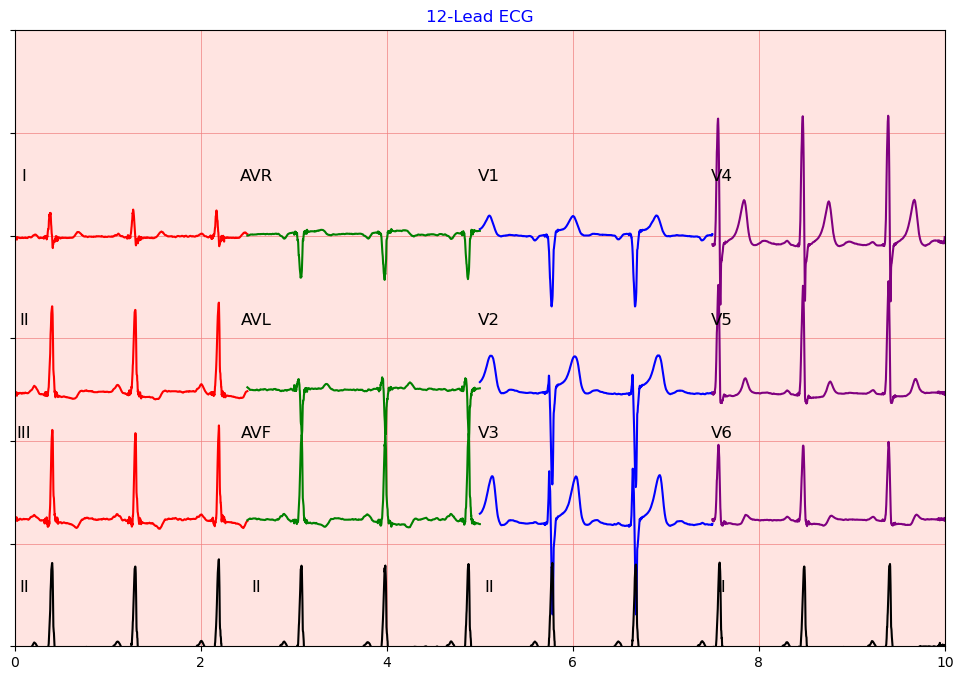

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
ecg_path = f'../../Desktop/user_ecg/3_data.pkl'

with open(ecg_path, 'rb') as f:
    ecg_data = pickle.load(f)

time_data = np.arange(len(ecg_data['I'])) / 500.0
# 그래프 크기 조절
plt.figure(figsize=(12,8))
colors_3 = ['black', 'black', 'black', 'black']

# 바탕색과 grid 추가
plt.gca().set_facecolor('mistyrose')
plt.grid(color='lightcoral', linestyle='-', linewidth=0.5)

# 리드 이름과 색상 설정
lead_names = ['I', 'AVR', 'V1', 'V4']
colors = ['red', 'green', 'blue', 'purple']
start_time = 0
for i, lead_name in enumerate(lead_names):
    lead_data = ecg_data[lead_name] + 8000
    end_time = start_time + 2.5
    color_idx = i % 4
    plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors[color_idx], label=lead_name)
    plt.text(start_time + 0.1, 9000, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
    start_time = end_time  # 다음 리드의 시작 시간으로 갱신

plt.ylim(0, 12000)


# 리드 이름과 색상 설정
lead_names_1 = ['II', 'AVL', 'V2', 'V5']
colors_1 = ['red', 'green', 'blue', 'purple']
start_time = 0
for i, lead_name in enumerate(lead_names_1):
    lead_data = ecg_data[lead_name] + 5000
    end_time = start_time + 2.5
    color_idx = i % 4
    plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors_1[color_idx], label=lead_name)
    plt.text(start_time + 0.1, 6200, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
    start_time = end_time  # 다음 리드의 시작 시간으로 갱신   

plt.ylim(0, 12000)

# 첫 번째 그래프 그리기
lead_names_2 = ['III', 'AVF', 'V3', 'V6']
colors_2 = ['red', 'green', 'blue', 'purple']
start_time = 0
for i, lead_name in enumerate(lead_names_2):
    lead_data = ecg_data[lead_name] + 2500  # y축 값에 2500을 더하기
    end_time = start_time + 2.5
    color_idx = i % 4
    plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors_2[color_idx], label=lead_name)
    plt.text(start_time + 0.1, 4000, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
    start_time = end_time

# 두 번째 그래프 그리기
lead_names_3 = ['II', 'II', 'II', 'II']
colors_3 = ['black', 'black', 'black', 'black']
start_time = 0
for i, lead_name in enumerate(lead_names_3):
    lead_data = ecg_data[lead_name]
    end_time = start_time + 2.5
    color_idx = i % 4
    plt.plot(time_data[(time_data >= start_time) & (time_data <= end_time)], lead_data[(time_data >= start_time) & (time_data <= end_time)], color=colors_3[color_idx], label=lead_name)
    plt.text(start_time + 0.1, 1000, lead_name, fontsize=12, color=colors_3[color_idx], ha='center', va='bottom')  # lead_name 표시 (고정된 y값인 4000 사용)
    start_time = end_time

plt.title('12-Lead ECG', color='blue')
plt.gca().set_yticklabels([])
plt.xlim(0, 10)  # x 축 범위 지정

plt.show()